Лысенко Никита 4.8 2020

# House Prices: Advanced Regression Techniques

Predict sales prices and practice feature engineering, RFs, and gradient boosting

Основным методом обучения я выбрал случайный лес.

In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import psutil
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (10, 8)

In [3]:
pd.set_option('display.max_columns', None)

## Начнём знакомиться с данными

In [4]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
y = train['SalePrice']

In [5]:
train.shape

(1460, 81)

In [6]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Имеется 81 признак, из которых 38 числовых и 43 категориальных:

In [8]:
numeric_columns = train.select_dtypes(include=['int64', 'float64']).columns
numeric_columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [9]:
len(numeric_columns)

38

Также среди числовых признаков есть 3 категориальных, которые необходимо отделить. 

In [10]:
object_int_columns = ['MSSubClass', 'OverallQual', 'OverallCond']

In [11]:
numeric_columns = numeric_columns.drop(object_int_columns)
numeric_columns

Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [12]:
object_columns = train.select_dtypes(include=['object']).columns
object_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [13]:
len(object_columns)

43

## Подготовка данных

Для успешного обучения нашей модели необходимо оба датасета привести в подобающий вид. 

Обработка данных разделяется на несколько этапов:

    1) Обработка пропущенных значений
    2) Удаление выбросов
    3) Нормализация данных
    4) Трансформация искажённых числовых признаков
    5) Удаление признаков с высоким коэффициентом корреляции
    6) Превращение категориальных признаков в числовые (Не забыть категориальные инт перевести в правильный вид!!!)
    
Так как в нашем датасете довольно мало данных (1460 объектов), важно их сохранить по максимуму.

### 1. Обработка пропущенных значений

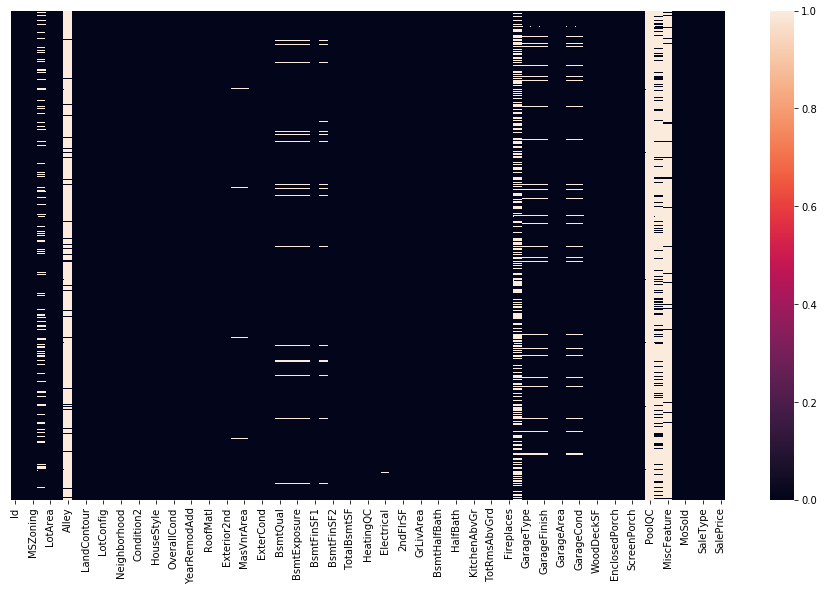

In [14]:
plt.figure(figsize=(16,9))
sns.heatmap(train.isnull(), yticklabels=False)

График heatmap по пустым значениям позволяет увидеть, что происходит с нашими данными. Чёрные области - наличие какого-либо значения, а белые - отсутствие. На глаз видно, что имеется 4 почти белых столбца, означающие почти полное отсутсвие значений. 

In [15]:
def calculate_null_values(df):
    """ Функция для подсчёта пропущенных значений. """
    res = dict()
    for col in df.columns:
        null_count = df[col].isnull().sum()
        if null_count > 0:
            null_percent = round(null_count / df.shape[0] * 100, 4)
            res[col] = (null_count, null_percent)
            print('{}:{} \t{}, \t{}%'.format(col, '\t' if len(col) < 7 else '', null_count, null_percent))
    return res

#### Заполенение пропусков в обучающей выборке train.csv

(Название колонки: количество пропусков, % от общего числа строк)

In [16]:
null_values_train = calculate_null_values(train)

LotFrontage: 	259, 	17.7397%
Alley:	 	1369, 	93.7671%
MasVnrType: 	8, 	0.5479%
MasVnrArea: 	8, 	0.5479%
BsmtQual: 	37, 	2.5342%
BsmtCond: 	37, 	2.5342%
BsmtExposure: 	38, 	2.6027%
BsmtFinType1: 	37, 	2.5342%
BsmtFinType2: 	38, 	2.6027%
Electrical: 	1, 	0.0685%
FireplaceQu: 	690, 	47.2603%
GarageType: 	81, 	5.5479%
GarageYrBlt: 	81, 	5.5479%
GarageFinish: 	81, 	5.5479%
GarageQual: 	81, 	5.5479%
GarageCond: 	81, 	5.5479%
PoolQC:	 	1453, 	99.5205%
Fence:	 	1179, 	80.7534%
MiscFeature: 	1406, 	96.3014%


In [17]:
len(null_values_train)

19

В обучающей выборке имеем 19 признаков c пропущенными значениями 

Глядя на heatmap и процентное соотношение пропусков в датасете, можно сделать следующие выводы:

    1) Есть 4 признака ('Alley', 'PoolQC', 'Fence', 'MiscFeature'), количество пропусков в которых слишком велико, следовательно от них можно избавиться;
    2) Один признак 'FireplaceQu' имеет около 50% пропусков. Соответственно, относительно этого признака нужно будет принять исключительное решение;
    3) Подавляющее большинство признаков имеют небольшой процент пропусков, поэтому есть смысл "побороться" за такие данные.

In [18]:
# 1. избавляемся от "плохих" признаков в обеих выборках
to_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature']
train.drop(to_drop, axis=1, inplace=True)
object_columns = object_columns.drop(to_drop)

In [19]:
train.shape

(1460, 77)

In [20]:
# 2. более подробно посмотрим на признак 'FireplaceQu'
train['FireplaceQu'].value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64

Признак 'FireplaceQu' или Fireplace quality описывает качество домашнего камина, следовательно, пропущенные признаки означают отсутствие камина как такогого. Лучшим способом "борьбы" в данной ситуации будет ввести новую категорию "Na".

In [21]:
train['FireplaceQu'] = train['FireplaceQu'].fillna('Na')

In [22]:
# 3. Обрабатываем остальные пропуски

In [23]:
null_values_train = calculate_null_values(train)

LotFrontage: 	259, 	17.7397%
MasVnrType: 	8, 	0.5479%
MasVnrArea: 	8, 	0.5479%
BsmtQual: 	37, 	2.5342%
BsmtCond: 	37, 	2.5342%
BsmtExposure: 	38, 	2.6027%
BsmtFinType1: 	37, 	2.5342%
BsmtFinType2: 	38, 	2.6027%
Electrical: 	1, 	0.0685%
GarageType: 	81, 	5.5479%
GarageYrBlt: 	81, 	5.5479%
GarageFinish: 	81, 	5.5479%
GarageQual: 	81, 	5.5479%
GarageCond: 	81, 	5.5479%


In [24]:
train[null_values_train.keys()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
LotFrontage     1201 non-null float64
MasVnrType      1452 non-null object
MasVnrArea      1452 non-null float64
BsmtQual        1423 non-null object
BsmtCond        1423 non-null object
BsmtExposure    1422 non-null object
BsmtFinType1    1423 non-null object
BsmtFinType2    1422 non-null object
Electrical      1459 non-null object
GarageType      1379 non-null object
GarageYrBlt     1379 non-null float64
GarageFinish    1379 non-null object
GarageQual      1379 non-null object
GarageCond      1379 non-null object
dtypes: float64(3), object(11)
memory usage: 159.8+ KB


Имеем 3 числовых и 11 категориальных признаков.

Для числовых признаков пропущенные значения заполним средними значениями:

In [25]:
numeric_missing_columns_train = train[null_values_train.keys()].select_dtypes(include=['float64']).columns
for col in numeric_missing_columns_train:
    train[col] = train[col].fillna(train[col].mean())
    
del numeric_missing_columns_train

С каждым категориальным признаком необходимо провести анализ.

In [26]:
categorical_missing_columns_train = train[null_values_train.keys()].select_dtypes(include=['object']).columns
categorical_missing_columns_train

Index(['MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'Electrical', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond'],
      dtype='object')

Пропущенные категориальные можно заполнять двумя способами:
    
    1) взять mode и пропуски заполнить самым часто встречающимся значением
    2) ввести новую категорию NA
  
В зависимости от того, за что отвечает признак, мы и будем принимать решение по дальнейшей обработке.

В ходе детального изучения признаков было выяснено, что отсутствующее значение в датасете означает отсутствие признака как такогого в предполагаемом доме. Следовательно, для каждого (за исключением двух) признака необходимо ввести новую категорию. 

В признаке "Electrical" не предусмотрена категория для пустого значения, следовательно, в данной ситуации все пропуски будем заполнять наиболее встречающимся значением, то есть модой.
В признаке "MasVnrType" предусмотрена категория "none" для отсутствующего значения.

In [27]:
train['Electrical'] = train['Electrical'].fillna(train['Electrical'].mode()[0])

In [28]:
categorical_missing_columns_train = categorical_missing_columns_train.drop('Electrical')
categorical_missing_columns_train = categorical_missing_columns_train.drop('MasVnrType')
for col in categorical_missing_columns_train:
    train[col] = train[col].fillna('Na')
    
del categorical_missing_columns_train

In [29]:
miss_cols_train_add_to_none = ['MasVnrType']
for col in miss_cols_train_add_to_none:
    train[col] = train[col].fillna('None')
    
del miss_cols_train_add_to_none

Проверим, все ли мы обработали пустые значения:

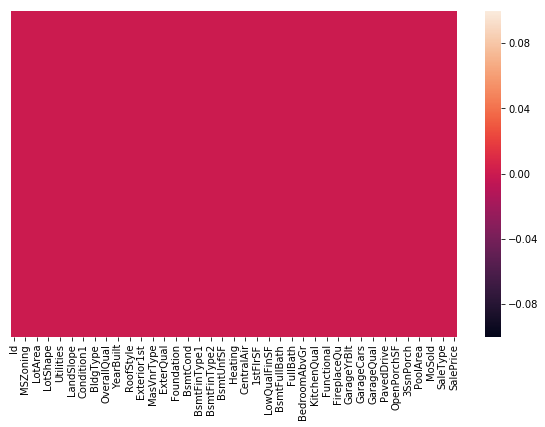

In [30]:
plt.figure(figsize=(10,6))
sns.heatmap(train.isnull(), yticklabels=False)

In [31]:
null_values_train = calculate_null_values(train)
null_values_train

{}

Как видно по графику heatmap и функции calculate_null_values(), в тренировочном датасете больше нет пропущенных значений.

### Заполенение пропусков в тестовой выборке test.csv

In [32]:
null_values_test = calculate_null_values(test)

MSZoning: 	4, 	0.2742%
LotFrontage: 	227, 	15.5586%
Alley:	 	1352, 	92.6662%
Utilities: 	2, 	0.1371%
Exterior1st: 	1, 	0.0685%
Exterior2nd: 	1, 	0.0685%
MasVnrType: 	16, 	1.0966%
MasVnrArea: 	15, 	1.0281%
BsmtQual: 	44, 	3.0158%
BsmtCond: 	45, 	3.0843%
BsmtExposure: 	44, 	3.0158%
BsmtFinType1: 	42, 	2.8787%
BsmtFinSF1: 	1, 	0.0685%
BsmtFinType2: 	42, 	2.8787%
BsmtFinSF2: 	1, 	0.0685%
BsmtUnfSF: 	1, 	0.0685%
TotalBsmtSF: 	1, 	0.0685%
BsmtFullBath: 	2, 	0.1371%
BsmtHalfBath: 	2, 	0.1371%
KitchenQual: 	1, 	0.0685%
Functional: 	2, 	0.1371%
FireplaceQu: 	730, 	50.0343%
GarageType: 	76, 	5.209%
GarageYrBlt: 	78, 	5.3461%
GarageFinish: 	78, 	5.3461%
GarageCars: 	1, 	0.0685%
GarageArea: 	1, 	0.0685%
GarageQual: 	78, 	5.3461%
GarageCond: 	78, 	5.3461%
PoolQC:	 	1456, 	99.7944%
Fence:	 	1169, 	80.1234%
MiscFeature: 	1408, 	96.5045%
SaleType: 	1, 	0.0685%


In [33]:
len(null_values_test)

33

В тестовой выборке имеем 33 признака c пропущенными значениями

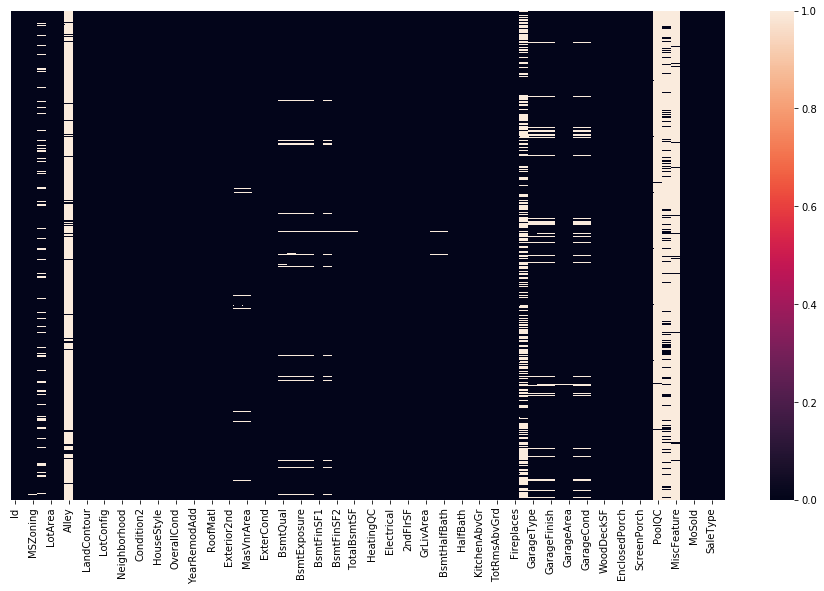

In [34]:
plt.figure(figsize=(16,9))
sns.heatmap(test.isnull(), yticklabels=False)

Имеем 3 числовых и 11 категориальных признаков.

Так же как и в тренировочной, избавляемся от признаков со слишком большим процентом пропусков

In [35]:
# 1. избавляемся от "плохих" признаков в обеих выборках
test.drop(to_drop, axis=1, inplace=True)

In [36]:
null_values_test = calculate_null_values(test)

MSZoning: 	4, 	0.2742%
LotFrontage: 	227, 	15.5586%
Utilities: 	2, 	0.1371%
Exterior1st: 	1, 	0.0685%
Exterior2nd: 	1, 	0.0685%
MasVnrType: 	16, 	1.0966%
MasVnrArea: 	15, 	1.0281%
BsmtQual: 	44, 	3.0158%
BsmtCond: 	45, 	3.0843%
BsmtExposure: 	44, 	3.0158%
BsmtFinType1: 	42, 	2.8787%
BsmtFinSF1: 	1, 	0.0685%
BsmtFinType2: 	42, 	2.8787%
BsmtFinSF2: 	1, 	0.0685%
BsmtUnfSF: 	1, 	0.0685%
TotalBsmtSF: 	1, 	0.0685%
BsmtFullBath: 	2, 	0.1371%
BsmtHalfBath: 	2, 	0.1371%
KitchenQual: 	1, 	0.0685%
Functional: 	2, 	0.1371%
FireplaceQu: 	730, 	50.0343%
GarageType: 	76, 	5.209%
GarageYrBlt: 	78, 	5.3461%
GarageFinish: 	78, 	5.3461%
GarageCars: 	1, 	0.0685%
GarageArea: 	1, 	0.0685%
GarageQual: 	78, 	5.3461%
GarageCond: 	78, 	5.3461%
SaleType: 	1, 	0.0685%


In [37]:
test[null_values_test.keys()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 29 columns):
MSZoning        1455 non-null object
LotFrontage     1232 non-null float64
Utilities       1457 non-null object
Exterior1st     1458 non-null object
Exterior2nd     1458 non-null object
MasVnrType      1443 non-null object
MasVnrArea      1444 non-null float64
BsmtQual        1415 non-null object
BsmtCond        1414 non-null object
BsmtExposure    1415 non-null object
BsmtFinType1    1417 non-null object
BsmtFinSF1      1458 non-null float64
BsmtFinType2    1417 non-null object
BsmtFinSF2      1458 non-null float64
BsmtUnfSF       1458 non-null float64
TotalBsmtSF     1458 non-null float64
BsmtFullBath    1457 non-null float64
BsmtHalfBath    1457 non-null float64
KitchenQual     1458 non-null object
Functional      1457 non-null object
FireplaceQu     729 non-null object
GarageType      1383 non-null object
GarageYrBlt     1381 non-null float64
GarageFinish    1381 non-null obje

Пропущенные числовые значения также заполним средними значениями:

In [38]:
numeric_missing_columns_test = test[null_values_test.keys()].select_dtypes(include=['float64']).columns
for col in numeric_missing_columns_test:
    test[col] = test[col].fillna(test[col].mean())
    
del numeric_missing_columns_test

##### Теперь заполним пустоты с категориальными значениями. 

In [39]:
categorical_missing_columns_test = test[null_values_test.keys()].select_dtypes(include=['object']).columns
categorical_missing_columns_test

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'SaleType'],
      dtype='object')

В ходе детального изучения признаков в тестовой выборке было выяснено, что решение по устранению пустых объектов необходимо принимать, глядя на описание каждого признака.

    FireplaceQu - вводим новую категорию NA
    MSZoning - mode, заполняем пустоты наиболее встречающимся значением
    Utilities - mode, заполняем пустоты наиболее встречающимся значением
    Exterior1st - mode, заполняем пустоты наиболее встречающимся значением
    Exterior2nd - mode, заполняем пустоты наиболее встречающимся значением
    MasVnrType - есть категория none, в которубю необходимо добавить все пропущенные значения
    BsmtQual - вводим новую категорию NA
    BsmtCond - вводим новую категорию NA
    BsmtExposure - вводим новую категорию NA
    BsmtFinType1 - вводим новую категорию NA
    BsmtFinType2 - вводим новую категорию NA
    KitchenQual - mode, заполняем пустоты наиболее встречающимся значением
    Functional - mode, заполняем пустоты наиболее встречающимся значением
    GarageType - вводим новую категорию NA
    GarageFinish - вводим новую категорию NA
    GarageQual - вводим новую категорию NA
    GarageCond - вводим новую категорию NA
    SaleType - mode, заполняем пустоты наиболее встречающимся значением

In [40]:
miss_cols_test_mode = ['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'KitchenQual', 'Functional', 
                       'SaleType']

miss_cols_test_new_cat_NA = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
                             'BsmtFinType2', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

miss_cols_test_add_to_none = ['MasVnrType']

In [41]:
for col in miss_cols_test_mode:
    test[col] = test[col].fillna(test[col].mode()[0])

del miss_cols_test_mode

In [42]:
for col in miss_cols_test_new_cat_NA:
    test[col] = test[col].fillna('Na')
    
del miss_cols_test_new_cat_NA

In [43]:
for col in miss_cols_test_add_to_none:
    test[col] = test[col].fillna('None')
    
del miss_cols_test_add_to_none

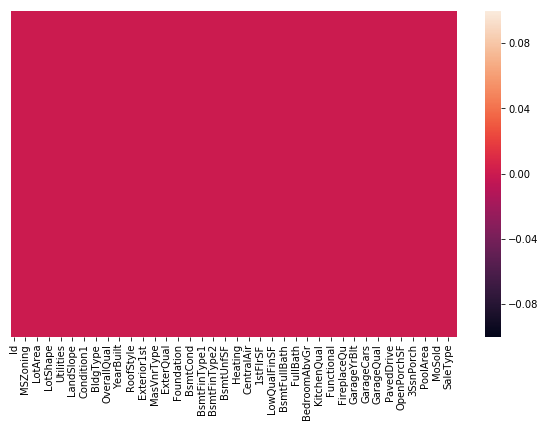

In [44]:
plt.figure(figsize=(10,6))
sns.heatmap(test.isnull(), yticklabels=False)

In [45]:
null_values_test = calculate_null_values(test)
null_values_test

{}

Как видно по графику heatmap и функции calculate_null_values(), в тестовом датасете больше нет пропущенных значений.

Первый этап обработки данных завершён.

## 2. Удаление выбросов

In [46]:
# и также практически не чувствителен к выбросам из-за случайного сэмлирования. 

Для того чтобы отследить выбросы, необходимо посмотреть на каждый числовой признак относительно целевого признака. 

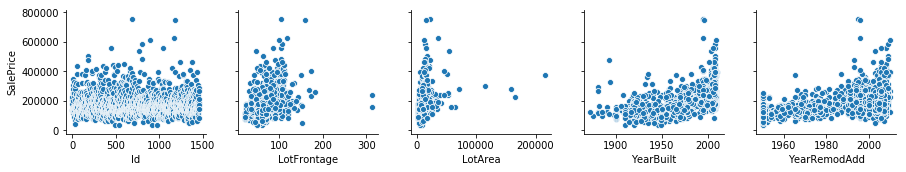

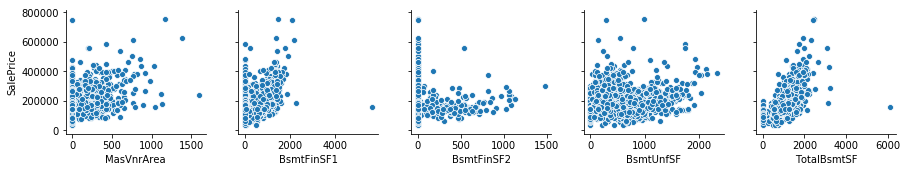

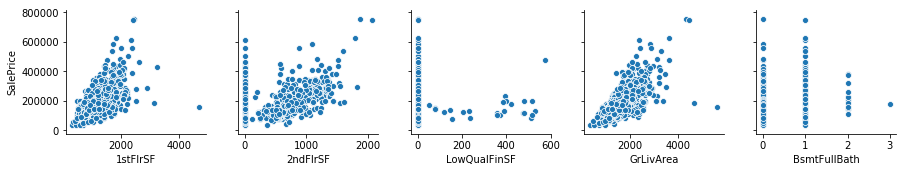

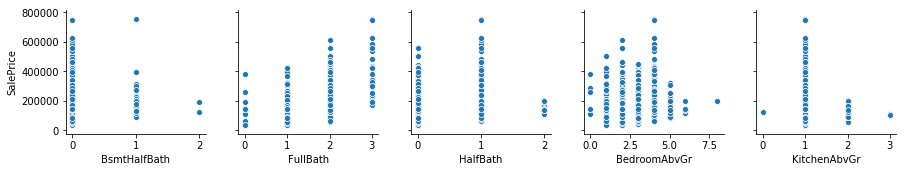

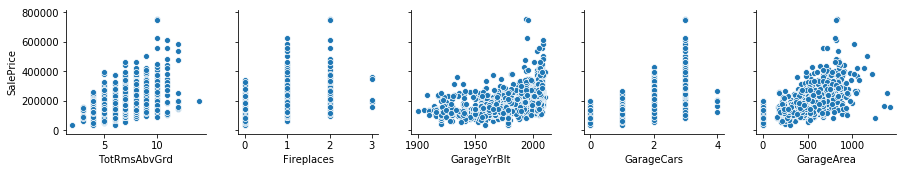

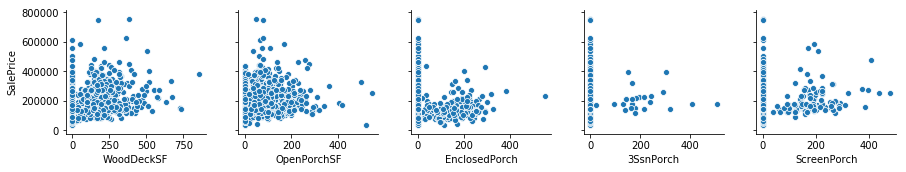

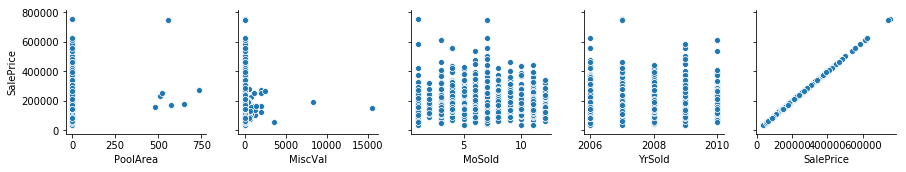

In [47]:
cols5 = []
for i in range(0, len(numeric_columns), 5):
    cols5.append(numeric_columns[i : i + 5])
    
# Далее выыведем графики зависимостей численных признаков от целевой переменной
for x in cols5:
    sns.pairplot(train, y_vars=['SalePrice'], x_vars=x)

Глядя на данные графики, можно сделать выводы о выбросах для каждого признака

Для подавляющего большинства признаков выбросов не наблюдается.
Однако есть признаки, у которых они всё таки наблюдаются:

    "LotArea" > 100000
    "LotFrontage" > 300
    "BsmtFinSF1" > 4000 
    "TotalBsmtSF" > 6000
    "1stFlrSF" > 4000
    "GrLivArea" > 5000
   
Запишем выбросы в переменную, чтобы далее от них избавиться.

In [48]:
outliers = {
    "LotArea": 100000, 
    "LotFrontage": 300,
    "BsmtFinSF1": 4000, 
    "TotalBsmtSF": 6000, 
    "1stFlrSF": 4000, 
    "GrLivArea": 5000
}

In [49]:
train.shape

(1460, 77)

In [50]:
for col in outliers: 
    train = train[train[col] < outliers[col]]

In [51]:
train.shape

(1454, 77)

## 3. Нормализация данных

Алгоритм случайного леса не нуждается в нормализации данных. Следовательно, данный этап предобработки можно пропустить.

## 4. Трансформация искажённых числовых признаков

Искажённые или асимметричные признаки - ещё одна проблема, которая может повлиять на качество модели. Алгоритмы машинного обучения подразумевают, что на вход подаются данные,имеющий гауссово распределие. 

Посмотрим на асимметрию в данных и преобразуем те признаки, у которых коэффициент асимметрии велик.

In [52]:
skewed = train[numeric_columns].apply(lambda x: stats.skew(x.astype('float')))
skewed

Id               -0.002172
LotFrontage       0.737587
LotArea           3.939136
YearBuilt        -0.613934
YearRemodAdd     -0.502464
MasVnrArea        2.693622
BsmtFinSF1        0.799002
BsmtFinSF2        4.279205
BsmtUnfSF         0.916339
TotalBsmtSF       0.574892
1stFlrSF          0.959662
2ndFlrSF          0.812052
LowQualFinSF      8.982890
GrLivArea         1.127647
BsmtFullBath      0.574673
BsmtHalfBath      4.121397
FullBath          0.044331
HalfBath          0.671805
BedroomAbvGr      0.213924
KitchenAbvGr      4.473226
TotRmsAbvGrd      0.667398
Fireplaces        0.632566
GarageYrBlt      -0.672618
GarageCars       -0.337971
GarageArea        0.133894
WoodDeckSF        1.518666
OpenPorchSF       2.365910
EnclosedPorch     3.078561
3SsnPorch        10.272009
ScreenPorch       4.108107
PoolArea         15.910404
MiscVal          24.469277
MoSold            0.214573
YrSold            0.096121
SalePrice         1.896903
dtype: float64

In [53]:
skewed = skewed[abs(skewed) > 0.65]
skewed

LotFrontage       0.737587
LotArea           3.939136
MasVnrArea        2.693622
BsmtFinSF1        0.799002
BsmtFinSF2        4.279205
BsmtUnfSF         0.916339
1stFlrSF          0.959662
2ndFlrSF          0.812052
LowQualFinSF      8.982890
GrLivArea         1.127647
BsmtHalfBath      4.121397
HalfBath          0.671805
KitchenAbvGr      4.473226
TotRmsAbvGrd      0.667398
GarageYrBlt      -0.672618
WoodDeckSF        1.518666
OpenPorchSF       2.365910
EnclosedPorch     3.078561
3SsnPorch        10.272009
ScreenPorch       4.108107
PoolArea         15.910404
MiscVal          24.469277
SalePrice         1.896903
dtype: float64

Имеется 24 признака с высоким коэффициентом асимметрии.

In [54]:
len(skewed)

23

Посмотрим на графики распределения наших численных признаков

In [55]:
def plot_skewed(df, skewed):
    plt.figure(figsize=(25,20))
    for i in range(len(skewed)):
        plt.subplot(7, 4, i + 1)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.5)
        ax = sns.distplot(df[skewed.index[i]])
        ax.legend(["Skewness: {:.2f}".format(df[skewed.index[i]].skew())], fontsize = 'xx-large')
        ax.set_xlabel(skewed.index[i], fontsize = 20)

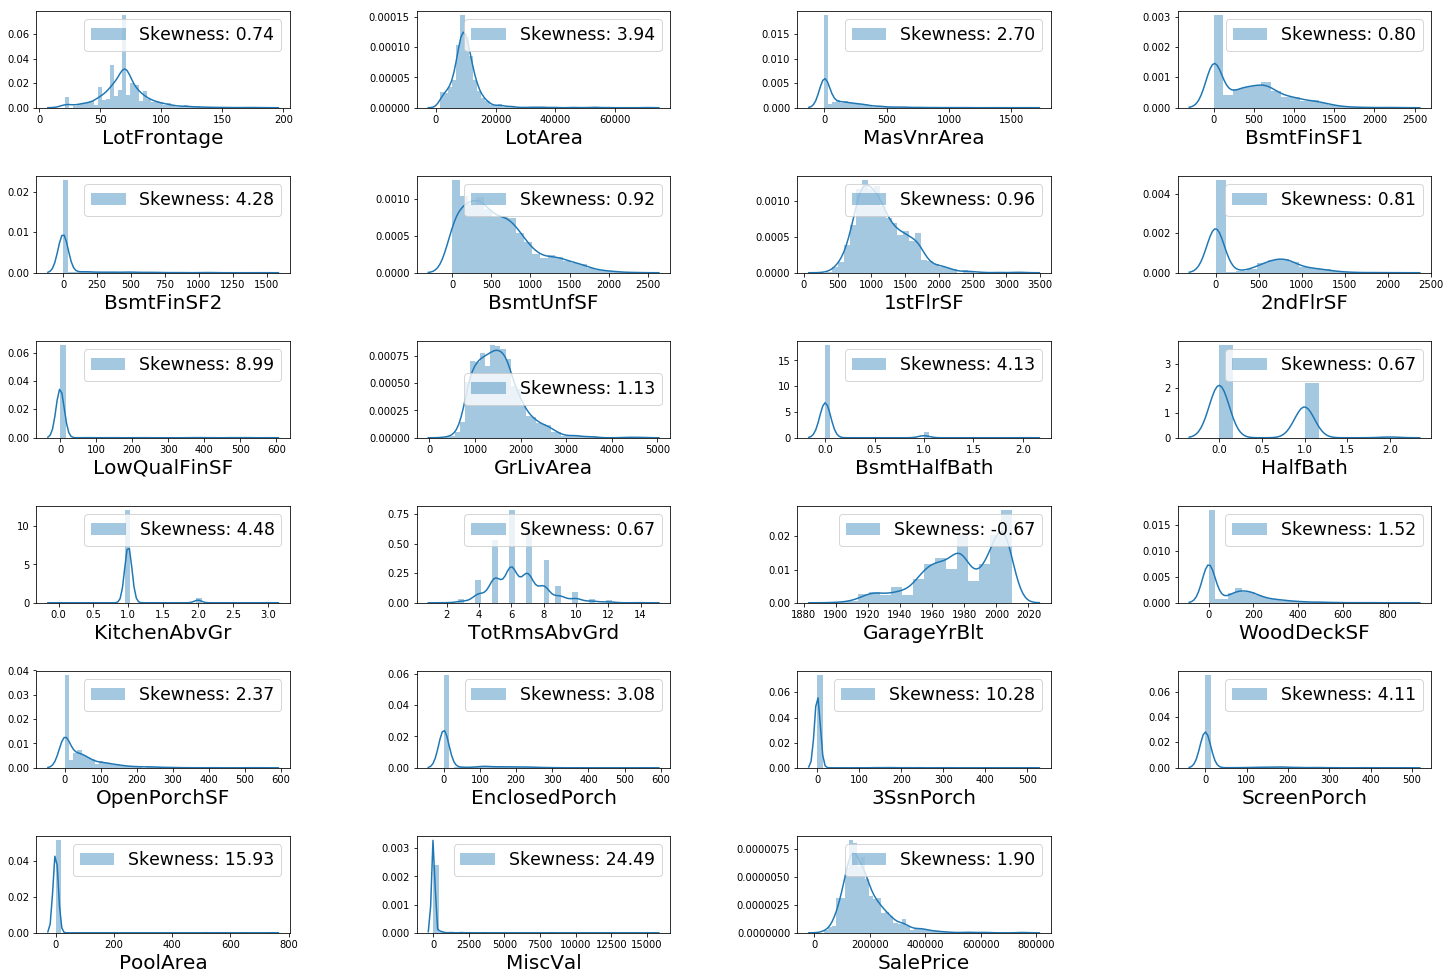

In [56]:
plot_skewed(df=train, skewed=skewed)

По графикам видно, что большинство наших признаков имеют позитивную ассиметрию (или правую). Побороться с данным видос ассиметрии можно с помощью логарифмирования.

Для примера посмотрим на распределение данных целевого признака "SalePrice" до и после логарифмирования. 

Text(0.5, 0, 'SalePrice')

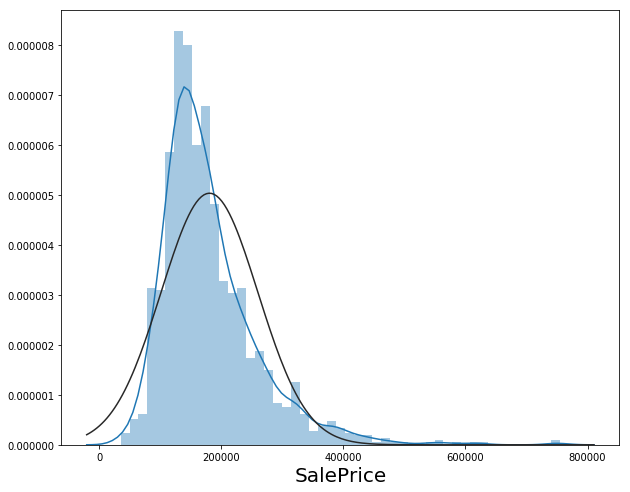

In [57]:
ax = sns.distplot(train['SalePrice'], fit=stats.norm)
ax.set_xlabel('SalePrice', fontsize = 20)

Text(0.5, 0, 'SalePrice')

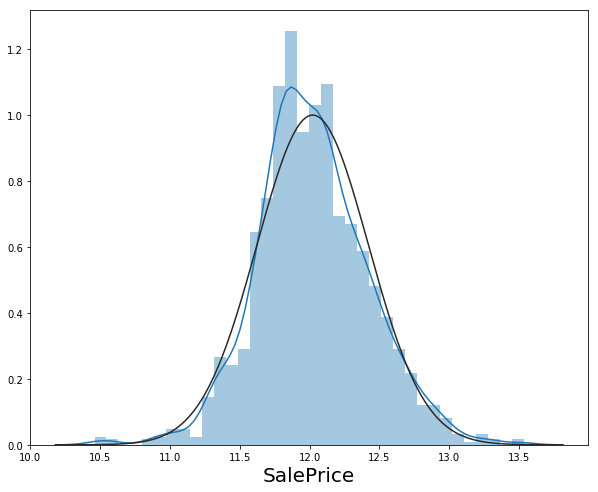

In [58]:
ax = sns.distplot(np.log(train['SalePrice']), fit=stats.norm)
ax.set_xlabel('SalePrice', fontsize = 20)

Видим, что после логарифмирования целевой признак действительно приобрел вид гауссового распределения.

Далее применим логарифмирование для всех числовых признаков в обоих датасетах. 

In [59]:
# так как log() превращает 0 в -inf, то используем функцию log(x+1), которая лучше работает с маленькими значениями
for col in skewed.index:
    train[col] = np.log(train[col] + 1)
    if col == 'SalePrice':
        continue
    test[col] = np.log(test[col] + 1)

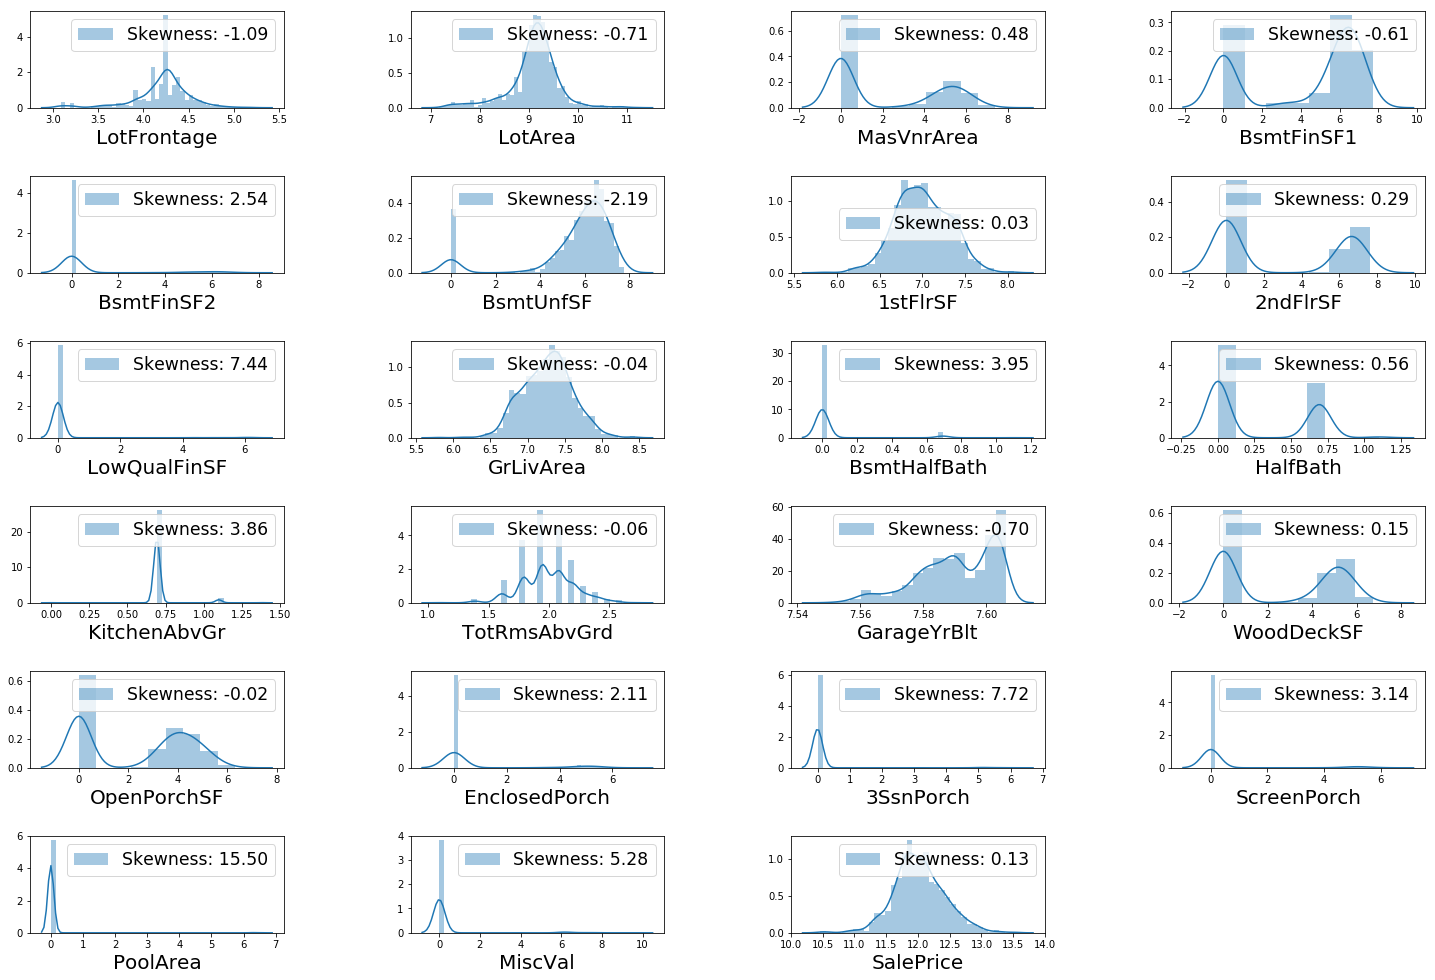

In [60]:
plot_skewed(df=train, skewed=skewed)

In [61]:
skewed = train[numeric_columns].apply(lambda x: stats.skew(x.astype('float')))
skewed = skewed[abs(skewed) > 0.65]
len(skewed)

13

С помощью логарифмирования удалось снизить коэффициент асимметрии у некоторых признаков, однако от остальных, у которых коэффициент велик, можно избавиться.

In [62]:
to_drop = skewed[abs(skewed) > 1]
to_drop

LotFrontage      -1.093353
BsmtFinSF2        2.535243
BsmtUnfSF        -2.183377
LowQualFinSF      7.436501
BsmtHalfBath      3.948892
KitchenAbvGr      3.855987
EnclosedPorch     2.103171
3SsnPorch         7.710341
ScreenPorch       3.138850
PoolArea         15.480172
MiscVal           5.271790
dtype: float64

In [63]:
to_drop = list(to_drop.index)
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
numeric_columns = numeric_columns.drop(to_drop)

In [64]:
del skewed

## 5. Удаление признаков с высоким коэффициентом корреляции

На данном шаге с помощью матрицы корреляции можно установить зависимость среди признаков. Если в датаете присутствует 2 или более признака, чья линейная зависимость близка к единице, то качество модели снизится.

(27.5, -0.5)

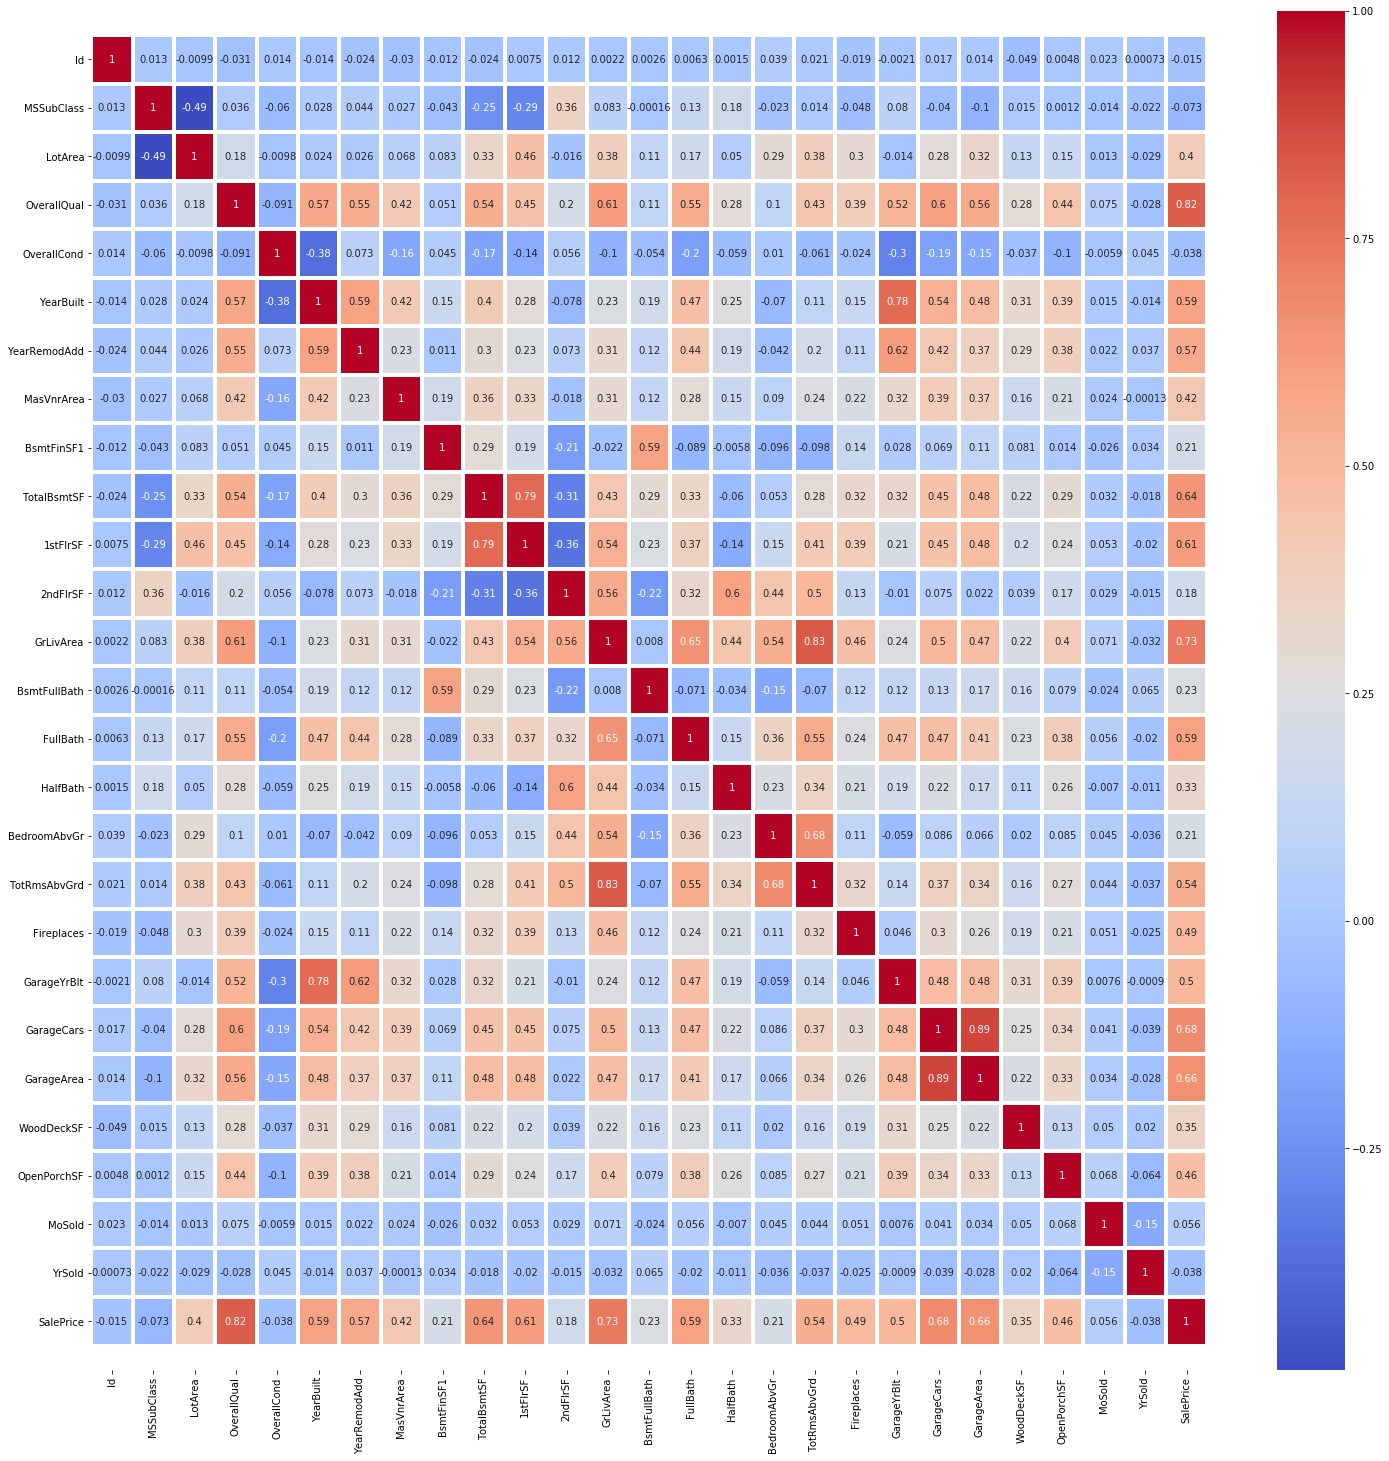

In [65]:
plt.figure(figsize=(25,25))
ax = sns.heatmap(train.corr(), cmap = "coolwarm", annot=True, linewidth=3)

# to fix the bug "first and last row cut in half of heatmap plot"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Посмотрим на признаки с максимальными значениями корреляции по отношению друг к другу

In [66]:
corr = train.corr()
corr_list = list()
for i in range(len(numeric_columns)):
    for j in range(i + 1, len(numeric_columns)):
        col1 = numeric_columns[i];
        col2 = numeric_columns[j];
        if corr[col1][col2] > 0.65:
            corr_list.append((col1, col2, corr[col1][col2]))

In [67]:
list(reversed(sorted(corr_list, key=lambda x: x[-1])))

[('GarageCars', 'GarageArea', 0.8879255985464204),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8294525081156641),
 ('TotalBsmtSF', '1stFlrSF', 0.7872837086770317),
 ('YearBuilt', 'GarageYrBlt', 0.7796622393567705),
 ('GrLivArea', 'SalePrice', 0.7340473091546997),
 ('BedroomAbvGr', 'TotRmsAbvGrd', 0.6841712997607883),
 ('GarageCars', 'SalePrice', 0.6816053774519594),
 ('GarageArea', 'SalePrice', 0.656710872737529),
 ('GrLivArea', 'FullBath', 0.6540699243376451)]

In [68]:
to_drop = ['GarageCars', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt', 'FullBath']

In [69]:
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
numeric_columns = numeric_columns.drop(to_drop)

In [70]:
train.shape

(1454, 61)

## 6. Превращение категориальных признаков в числовые

Посмотрим подробнее на каждый категориальный признак

In [162]:
def plot_barh(df, cols, ncols=4):
    num_col = 0
    for i in range(len(cols) // ncols):
        fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(12, 3), dpi=200)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.5)
        for j in range(ncols):
            num_col += 1
            ax = df[cols[num_col]].value_counts().plot.barh(ax=axes[j])
            ax.set_xlabel(cols[num_col], fontsize = 10)

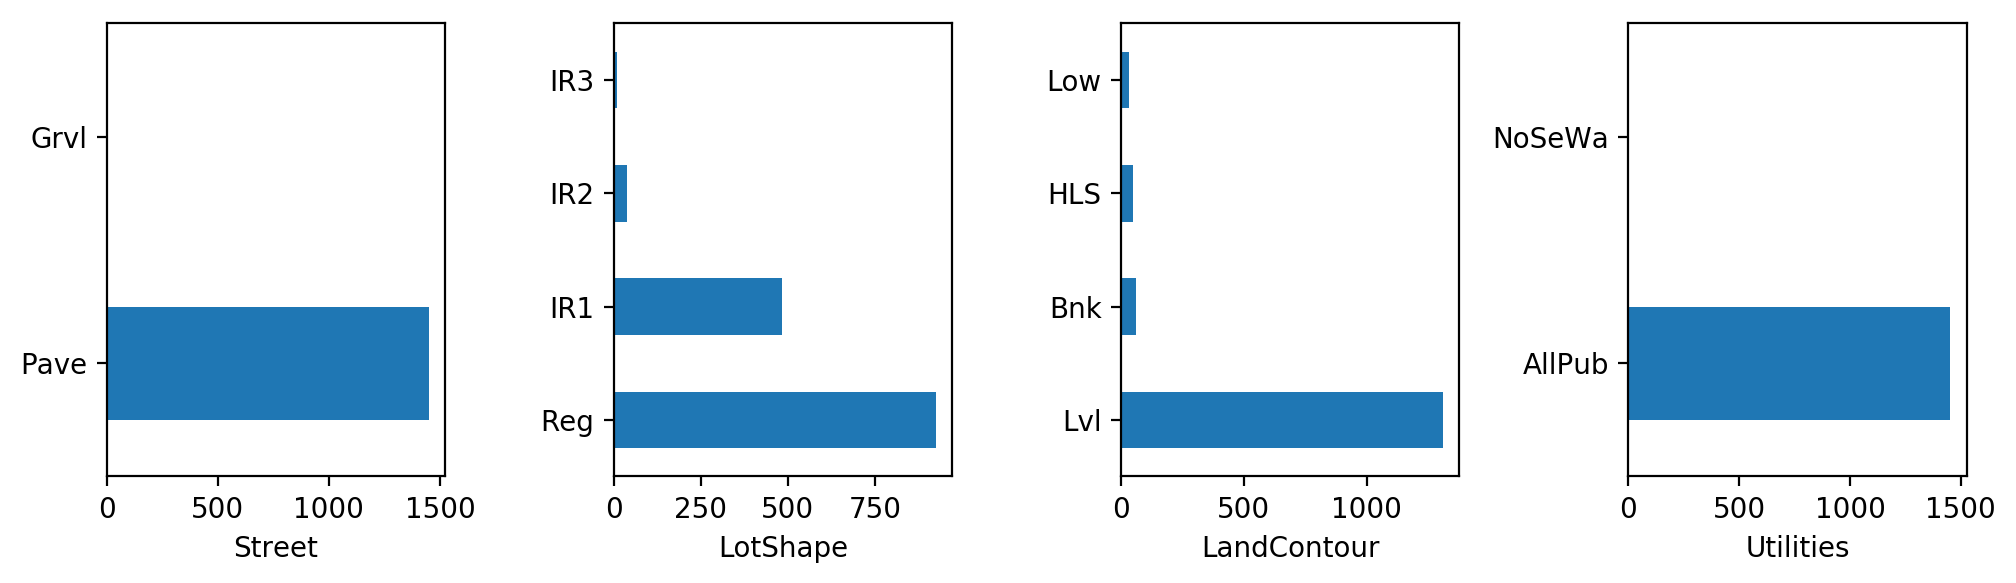

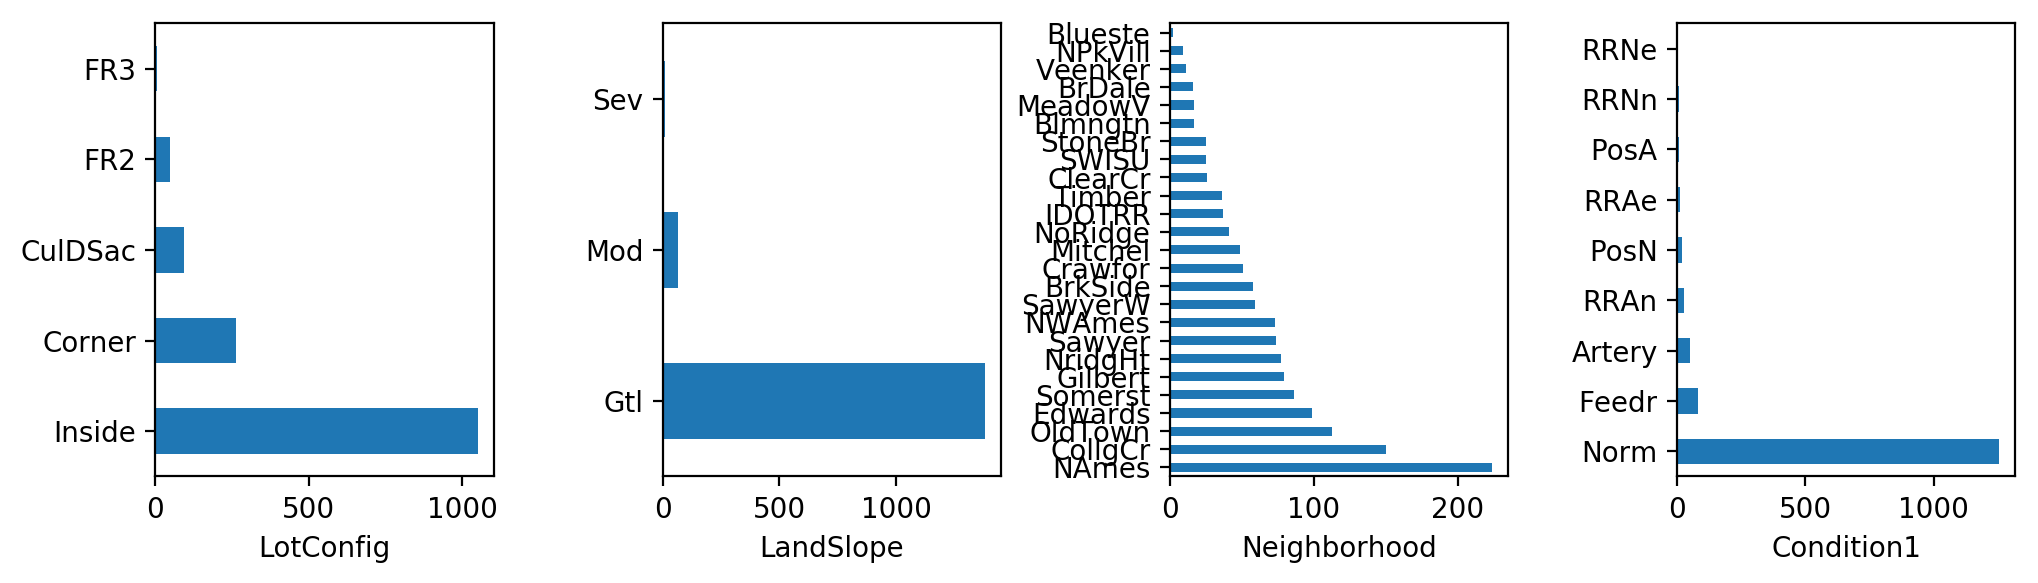

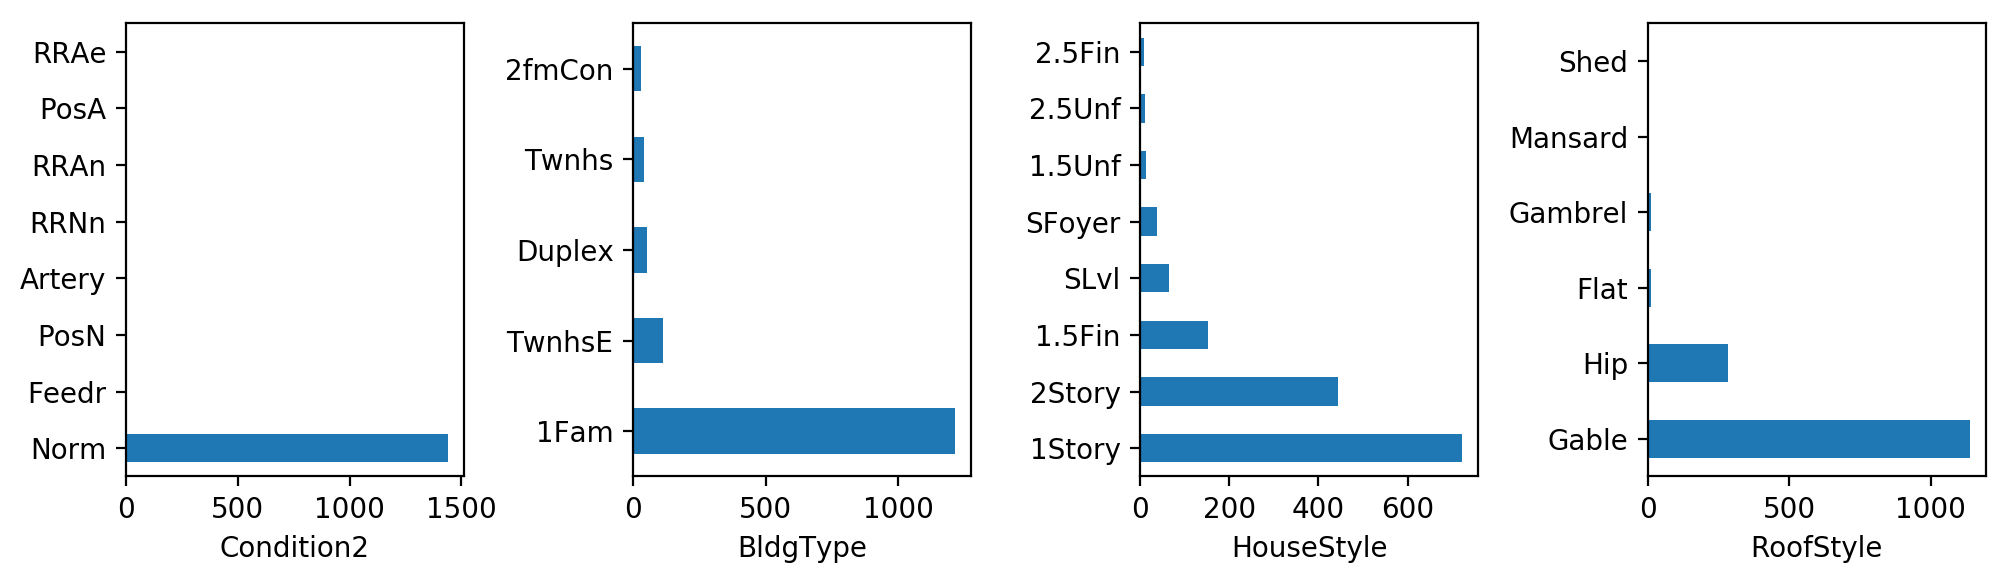

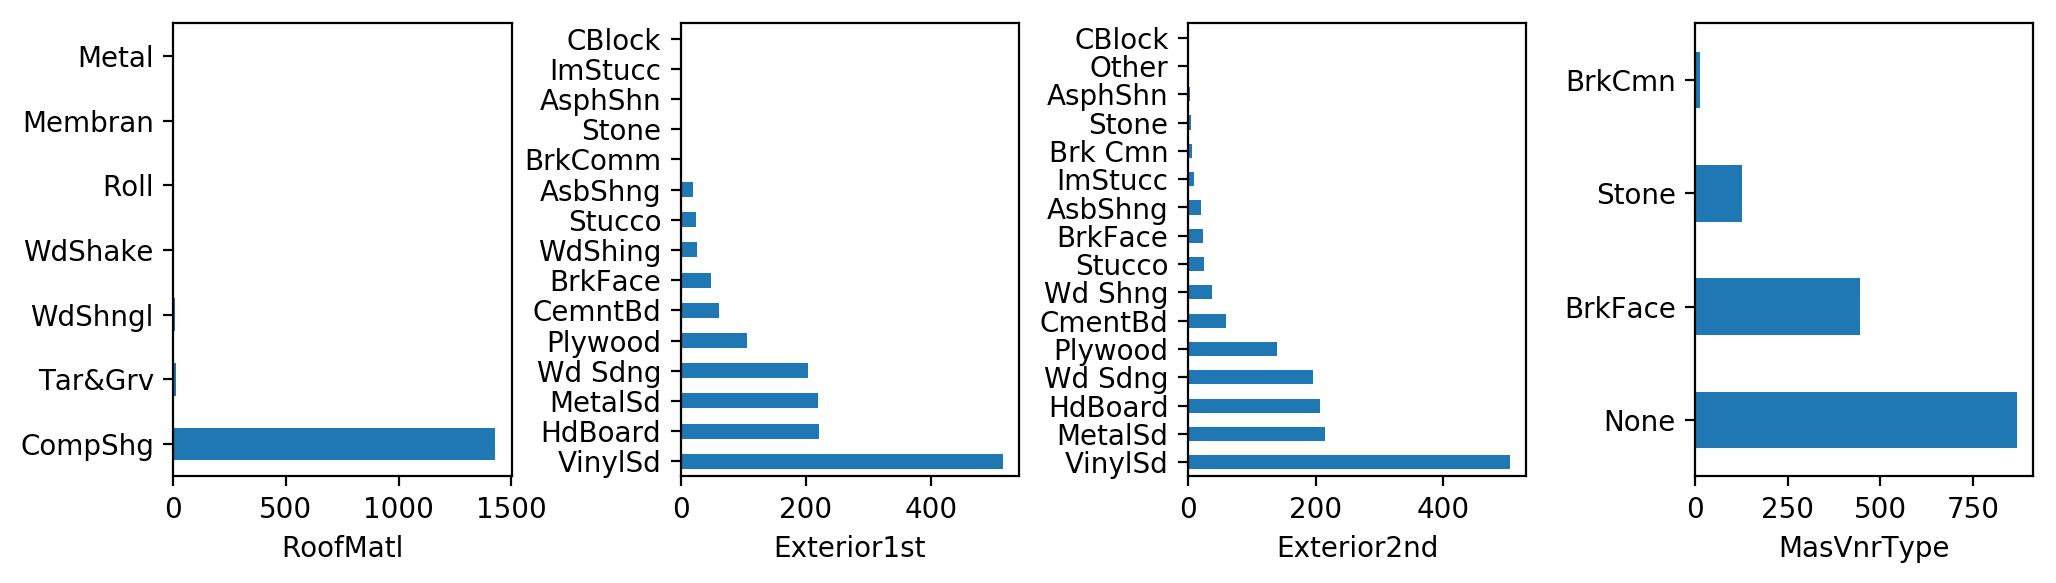

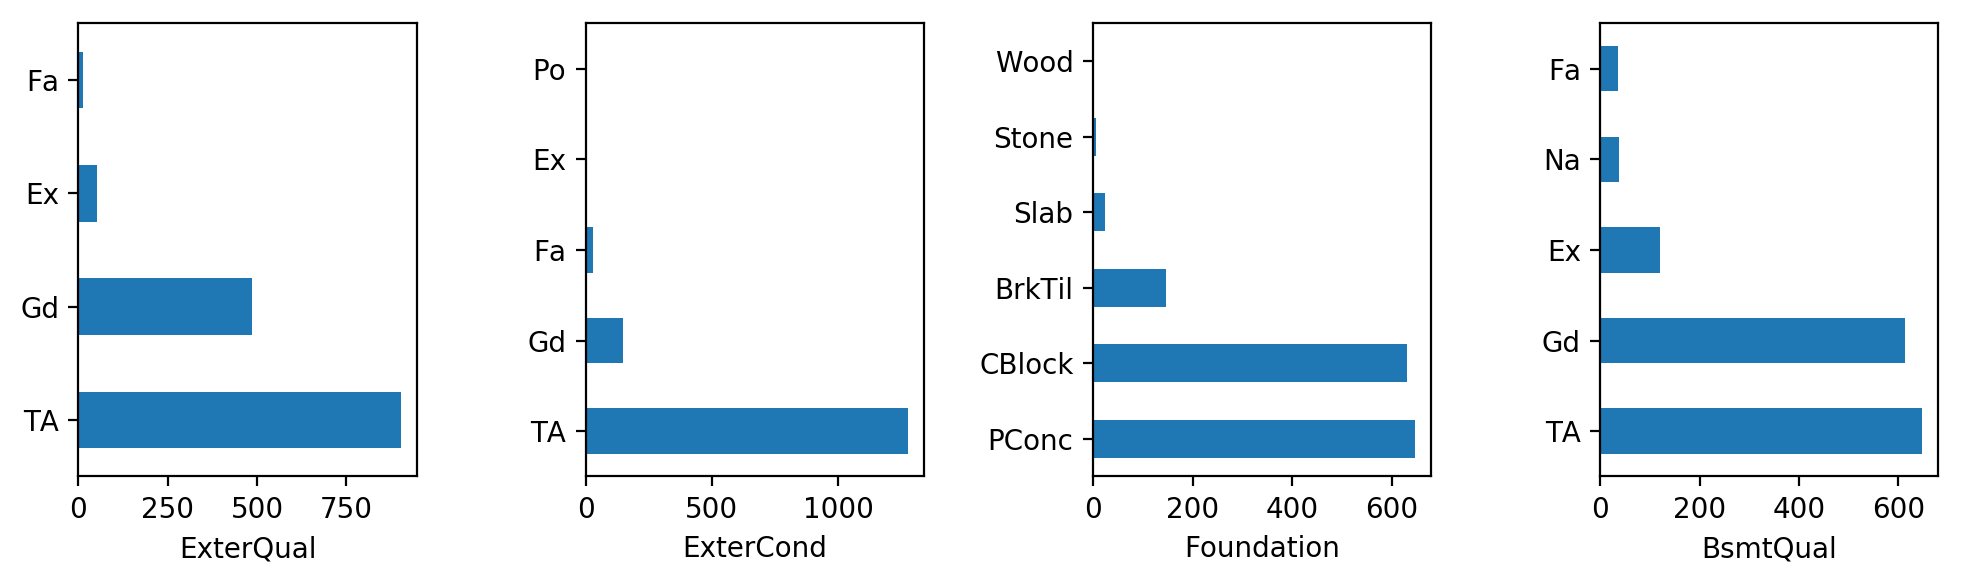

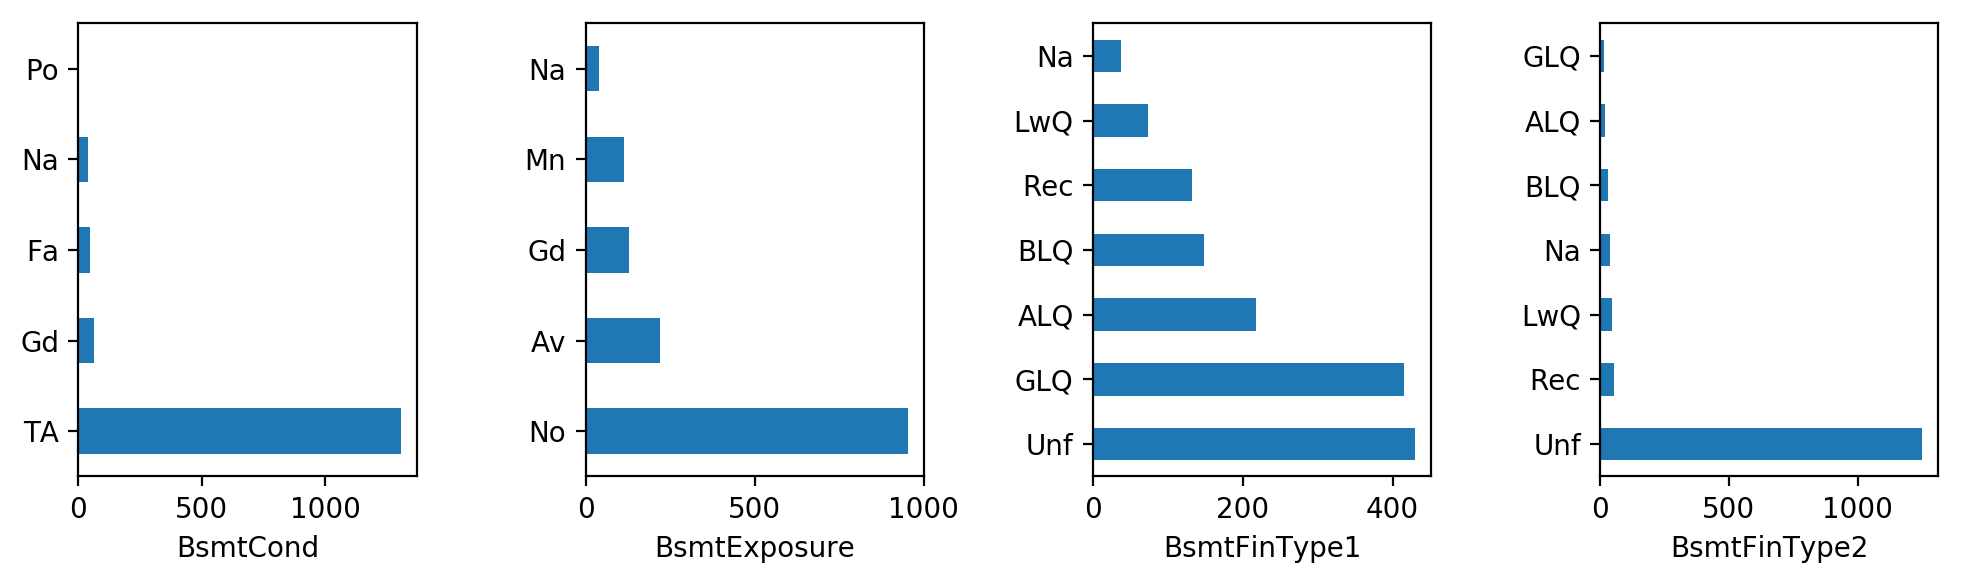

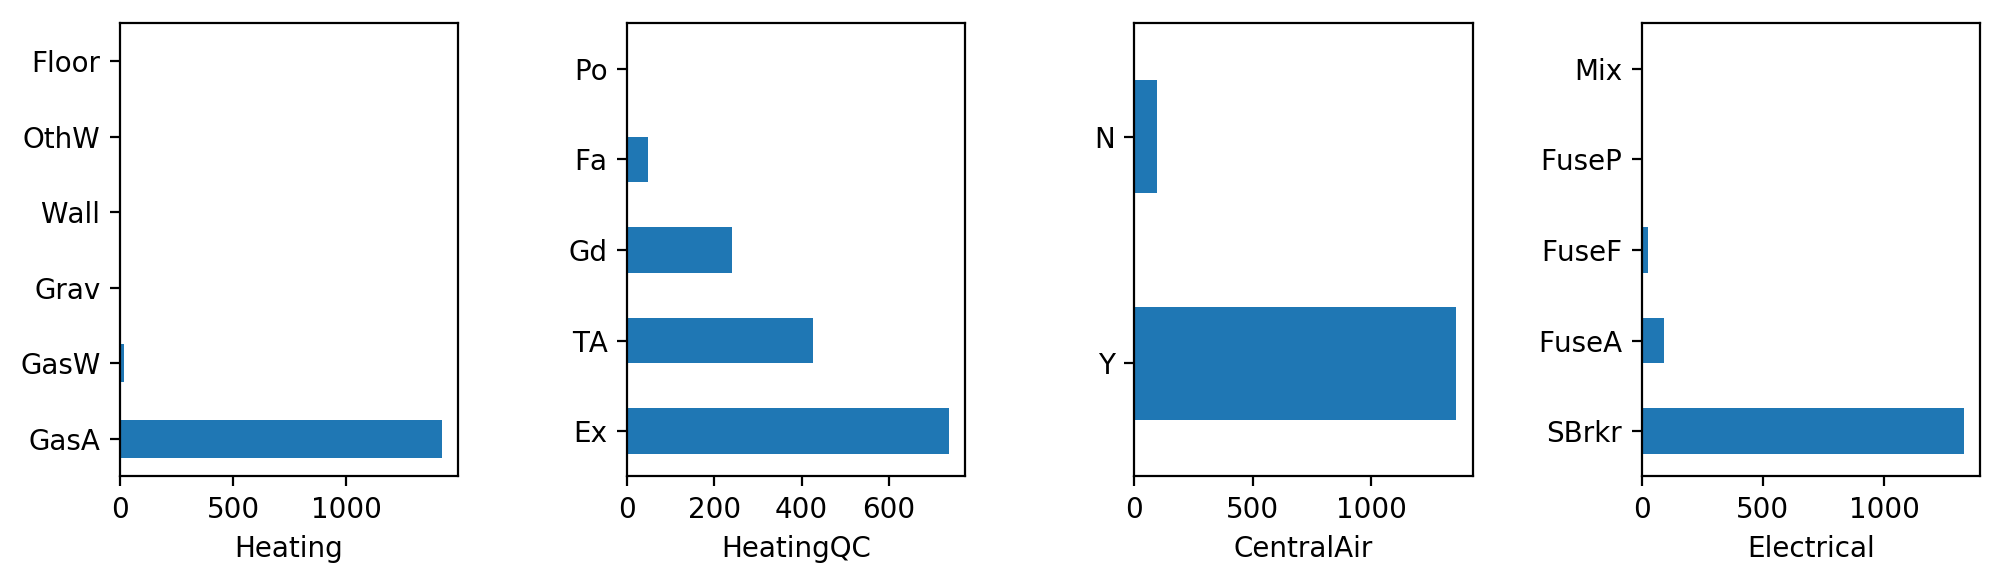

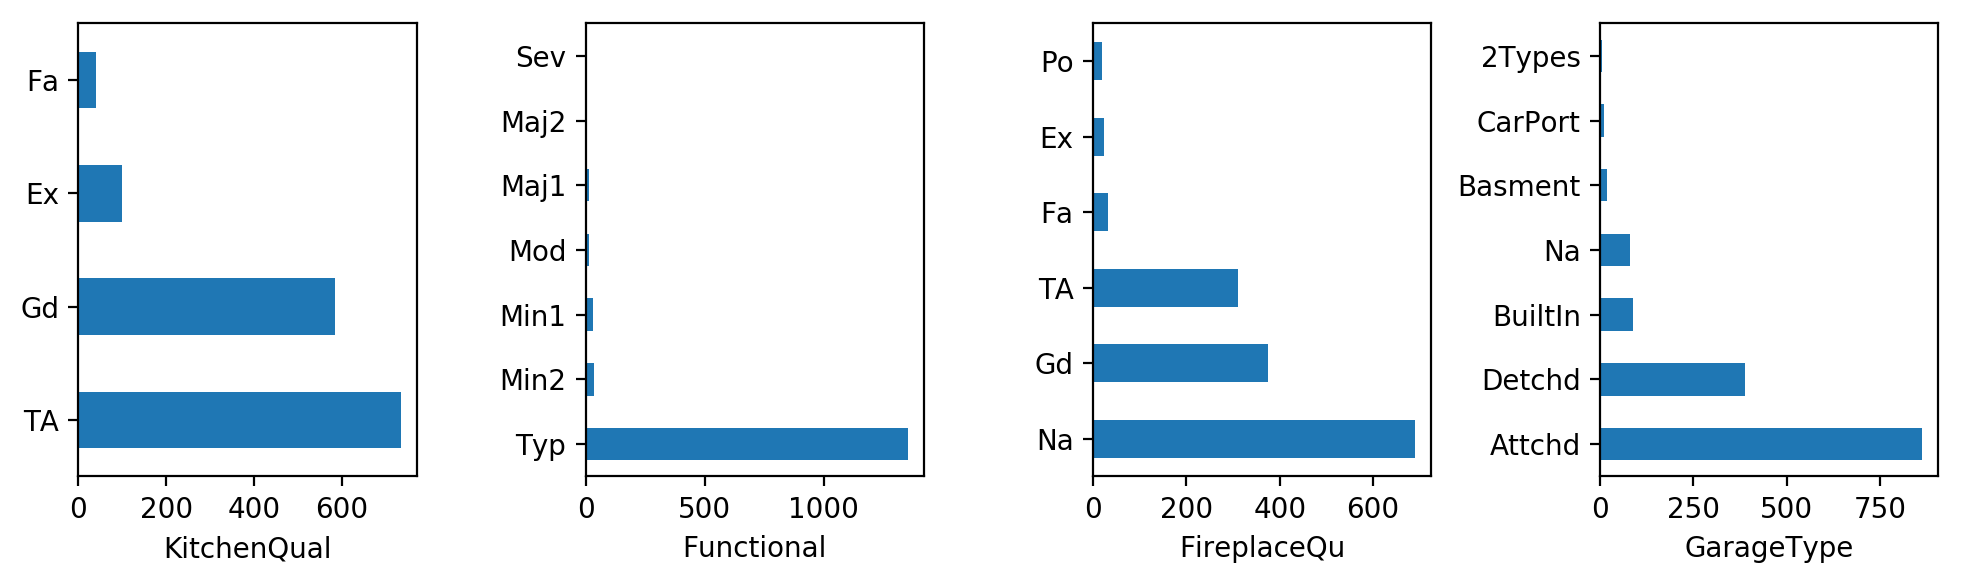

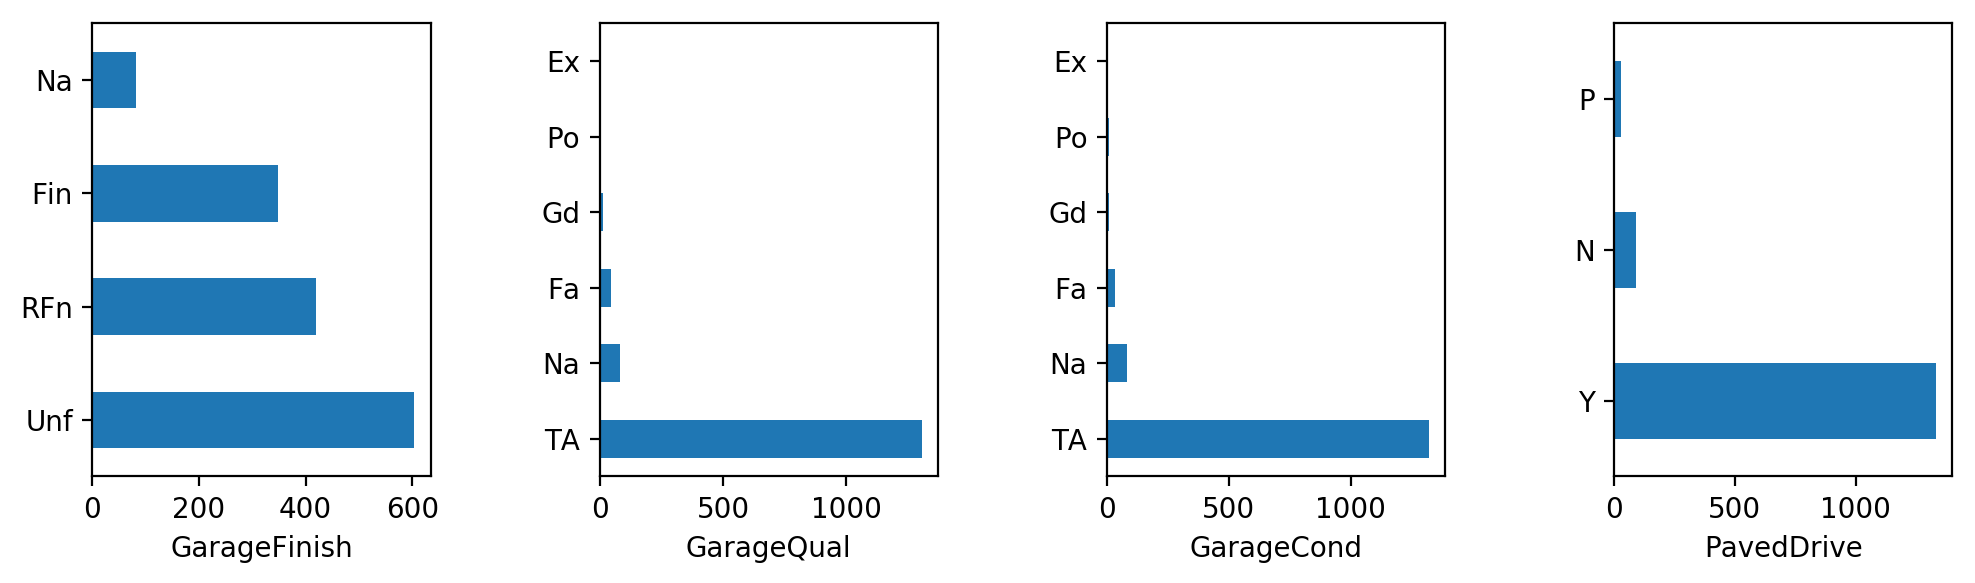

In [164]:
plot_barh(df=train, cols=object_columns)

Имеется несколько признаков, в которых одна категория значительно преобладает над другими.  

Например:

In [172]:
train['Utilities'].value_counts()
train['Heating'].value_counts()

GasA     1423
GasW       17
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

Подобные признаки не смогут положительно повлиять на качество нашей модели.

In [173]:
to_drop = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating']

In [174]:
train.drop(to_drop, axis=1, inplace=True)
test.drop(to_drop, axis=1, inplace=True)
object_columns = object_columns.drop(to_drop)

In [175]:
train.shape

(1454, 56)

Длаее категории строчного типа следует привести к вещественному.
Однозначно отобразим каждое значение в уникальное число с помощью класса LabelEncoder библиотеки sklearn. Алгоритм случайного леса не является линейным алгоритмом, следоветльно, такой вид преобразования не скажется негативно на качетсве модели.

In [180]:
label_encoder = LabelEncoder()

for col in object_columns:
    train[col] = label_encoder.fit_transform(train[col])
    test[col] = label_encoder.fit_transform(test[col])
train.head()

,Id,MSSubClass,MSZoning,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,TotalBsmtSF,HeatingQC,CentralAir,Electrical,2ndFlrSF,GrLivArea,BsmtFullBath,HalfBath,BedroomAbvGr,KitchenQual,Functional,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,9.042040,3,3,4,0,5,2,0,5,7,5,2003,2003,1,12,13,1,5.283204,2,4,2,2,4,4,2,6.561031,6,856,0,1,4,6.751101,7.444833,1,0.693147,3,2,6,0,3,1,2,548,5,5,2,0.000000,4.127134,2,2008,8,4,12.247699
1,2,20,3,9.169623,3,3,2,0,24,1,0,2,6,8,1976,1976,1,8,8,2,0.000000,3,4,1,2,4,1,0,6.886532,6,1262,0,1,4,0.000000,7.141245,0,0.000000,3,3,6,1,5,1,2,460,5,5,2,5.700444,0.000000,5,2007,8,4,12.109016
2,3,60,3,9.328212,0,3,4,0,5,2,0,5,7,5,2001,2002,1,12,13,1,5.093750,2,4,2,2,4,2,2,6.188264,6,920,0,1,4,6.765039,7.488294,1,0.693147,3,2,6,1,5,1,2,608,5,5,2,0.000000,3.761200,9,2008,8,4,12.317171
3,4,70,3,9.164401,0,3,0,0,6,2,0,5,7,5,1915,1970,1,13,15,2,0.000000,3,4,0,4,1,4,0,5.379897,6,756,2,1,4,6.629363,7.448916,1,0.000000,3,2,6,1,2,5,3,642,5,5,2,0.000000,3.583519,2,2006,8,0,11.849405
4,5,60,3,9.565284,0,3,2,0,15,2,0,5,8,5,2000,2000,1,12,13,1,5.860786,2,4,2,2,4,0,2,6.486161,6,1145,0,1,4,6.960348,7.695758,1,0.693147,4,2,6,1,5,1,2,836,5,5,2,5.262690,4.442651,12,2008,8,4,12.429220


In [188]:
X_train = train.drop('SalePrice', axis=1)
y_train = train['SalePrice']
X_test = test
y_test = pd.read_csv('data/sample_submission.csv')

In [202]:
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)
rf_predict

array([11.77347232, 11.89702682, 12.07060356, ..., 11.88469533,
       11.63417155, 12.34625163])

In [199]:
y_test.shape

(1459, 2)

In [204]:
err = np.sqrt(mean_squared_error(rf_predict, np.log(y_test['SalePrice'] + 1)))
err

0.38188406509644046

In [205]:
def evaluate(model, X, y, k=10):
    kf = KFold(n_splits=k, shuffle=True, random_state=2)
    y_pr = np.zeros((X.shape[0],))
    for train_index, test_index in kf.split(X):
        X_tr, X_te = X.iloc[train_index], X.iloc[test_index]
        y_tr, y_te = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_tr, y_tr)
        y_pr[test_index] = model.predict(X_te)
    err = np.sqrt(mean_squared_error(y_pr, y))
    print("RMSE: %.5f" % err)
def coef(model, X):
    for l, r in sorted(zip(X.columns, model.coef_), key=lambda x: abs(x[1]), reverse=True)[:5]:
        print("(%s, %.5f)" % (l, r))
def print_params(est, X, y, n=100):
    print("Chosen parameter on %d datapoints: %s" % 
          (n,est.fit(X[:n], y[:n]).best_params_))
def generate_submission(model, X):
    suffix = model.__class__.__name__.lower()
    y_pr = model.predict(X)
    result = np.exp(y_pr)
    submission = pd.DataFrame({'Id': X.index.values, 'SalePrice': result})
    submission.to_csv("submission_" + suffix + ".csv", index=None)

In [208]:
nJobs = psutil.cpu_count()
nJobs

4

In [209]:
from sklearn.ensemble import RandomForestRegressor
n_estimators = [100, 200, 400, 800, 1600]
max_features = [0.05, 0.15, 0.30, 0.60, 0.80, "sqrt", "log2", None]
max_depths = [5, 10, 15, 20]
min_samples_leaves = [1, 2, 4]
params = {"n_jobs": nJobs}
rf = RandomForestRegressor(**params)
est = GridSearchCV(rf, param_grid={"n_estimators": n_estimators, 
                                   "max_features": max_features,
                                   "max_depth": max_depths,
                                   "min_samples_leaf": min_samples_leaves
                                  })

In [210]:
%%time
print_params(est, X_train, y_train, 400)

Chosen parameter on 400 datapoints: {'max_depth': 20, 'max_features': 0.3, 'min_samples_leaf': 1, 'n_estimators': 400}
CPU times: user 10min 54s, sys: 1min 15s, total: 12min 9s
Wall time: 18min 31s


In [212]:
kFold = 10
params = {"n_jobs": nJobs, 'max_depth': 20, 'max_features': 0.3, 
          'min_samples_leaf': 1, 'n_estimators': 800}
rf = RandomForestRegressor(**params)
# cross validation
evaluate(rf, X_train, y_train, kFold)

RMSE: 0.13591


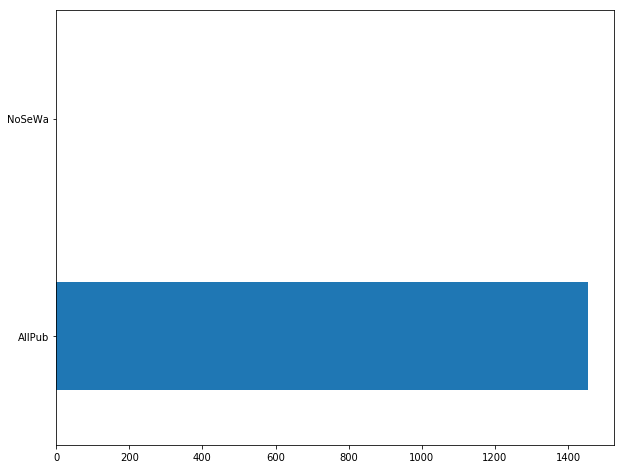

In [73]:
train['Utilities'].value_counts().plot.barh()

Метод fit этого класса находит все уникальные значения и строит таблицу для соответствия каждой категории некоторому числу, а метод transform непосредственно преобразует значения в числа. После fit у label_encoder будет доступно поле classes_, содержащее все уникальные значения. Можно их пронумеровать и убедиться, что преобразование выполнено верно.

In [ ]:
object_columns
object_int_columns

In [ ]:
# df = df.drop(['YrSold',
#  'LowQualFinSF',
#  'MiscVal',
#  'BsmtHalfBath',
#  'BsmtFinSF2',
#  '3SsnPorch',
#  'MoSold'],axis=1)

In [ ]:
# conver in month abbrevation
import calendar
df['MoSold'] = df['MoSold'].apply(lambda x : calendar.month_abbr[x])
df['MoSold'].unique()
array(['Feb', 'May', 'Sep', 'Dec', 'Oct', 'Aug', 'Nov', 'Apr', 'Jan',
       'Jul', 'Mar', 'Jun'], dtype=object)